In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tsr.src.api_osmr import get_matrix, parse_coordinates
from tsr.src.routing import optimize_routes, plot_route
from app.utils.utils import df_factory

import geopandas as gpd

In [ ]:
#!poetry add seaborn
# !git clone https://github.com/albertferre/travelling-salesman-routing.git

In [63]:
#permafrost_df = pd.read_csv(r"C:\JupyterNotebooks\projects\bus-route-builder\data\permafrost.csv")
#permafrost_df

df = df_factory(r"C:\JupyterNotebooks\projects\bus-route-builder\app\data\russia_cities.geojson")

In [65]:
df = df.rename(columns={"latitude": "lat", "longitude": "lng"})

In [69]:
cities = df.groupby(["city"])[["lat", "lng"]].median().reset_index()
cities.head()

,city,lat,lng
0,Абакан,53.639847,91.463417
1,Ангарск,52.497387,103.810827
2,Арзамас,55.414129,43.757412
3,Армавир,44.989030,41.037963
4,Артём,43.293950,132.248895


In [75]:
#response_distances["distances"][0]
#response_distances
# response_distances[response_distances["distances"] == None] = 0
# response_distances["distances"][0]

#postprocessed_distances = [[0 if x == None else x for x in array] for array in response_distances["distances"]]
cities = cities.head(20)

In [76]:
cities

,city,lat,lng
0,Абакан,53.639847,91.463417
1,Ангарск,52.497387,103.810827
2,Арзамас,55.414129,43.757412
3,Армавир,44.989030,41.037963
4,Артём,43.293950,132.248895
5,Архангельск,64.530936,40.284938
6,Астрахань,46.269656,47.871116
7,Ачинск,56.223253,90.359950
8,Балаково,52.008130,47.704080
9,Балашиха,55.792072,38.049962


In [78]:
# Extract the list of cities from the "cities" DataFrame
cities_list = cities.city

# Parse coordinates for the cities
coordinates = parse_coordinates(cities)

# Get the distance matrix for the cities using the OSRM API
response_distances = get_matrix(coordinates)

# Postprocess


# Convert the distances to integer values (required by ortools)
distances = np.array(response_distances["distances"]).astype(int)

# Set the starting city for the route (change if needed)
# starting_city = "Ulldecona"
starting_city = "Братск"

# Find the index of the starting city in the cities_list
depot_index = int(cities_list.index[cities_list == starting_city][0])

# Optimize the route using the distance matrix and starting city index
idx_route = optimize_routes(distances, depot_index, list(cities_list))

Route for vehicle:
 Братск -> Ангарск -> Благовещенск -> Биробиджан -> Артём -> Абакан -> Белорецк -> Балаково -> Астрахань -> Армавир -> Батайск -> Белгород -> Балашиха -> Арзамас -> Архангельск -> Березники -> Бердск -> Барнаул -> Бийск -> Ачинск -> Братск
Route distance: 23174.1km



In [79]:
# Create a DataFrame with the best route
df_best_route = cities.iloc[idx_route]

# Get the coordinates of the best route
coordinates = list(zip(df_best_route["lat"], df_best_route["lng"]))

# Plot the best route on a Folium map
my_map = plot_route(coordinates, dist=30000, zoom_start=11)
my_map

In [81]:
# Iterate over each unique city in the places data
for city in cities.city.unique():
    print(f"Planning route for {city}")

    # Select the first 10 points of sales for the current city
    df_city = cities[cities.city == city][:10].reset_index(drop=True)

    # Parse coordinates for the selected points of sales
    coordinates = parse_coordinates(df_city)

    # Get the distance matrix for the selected points of sales using the OSRM API
    response_distances = get_matrix(coordinates)

    # Convert the distances to integer values (required by ortools)
    distances = np.array(response_distances["distances"]).astype(int)

    # Set the names of the points of sales for labeling the route
    pos_names = list(df_city.name)

    # Setting the farthest point as the start point
    # Calculate the median tuple for the distance matrix
    coordinates_tuples = np.array(response_distances["distances"]).astype(int)
    median_tuple = tuple(np.median(np.array(coordinates_tuples), axis=0))

    # Calculate the Euclidean distance of each tuple from the median tuple
    distances_tuples = [
        np.linalg.norm(np.array(t) - np.array(median_tuple)) for t in coordinates_tuples
    ]

    # Find the index of the tuple with the maximum distance
    farthest_index = max(enumerate(distances_tuples), key=lambda x: x[1])[0]

    # Optimize the route using the distance matrix and farthest point index as the starting point
    best_route = optimize_routes(distances, farthest_index, pos_names)[:-1]

    # Save the best route to a CSV file with the city name in the output folder
    df_city.name[best_route].reset_index(drop=True).to_csv(
        f"data/output/{city}_routing.csv"
    )

    # Plot the best route on the map for the city "Ulldecona" (first city in the iteration)
    if city == "Ulldecona":
        df_best_route = df_city.iloc[best_route]
        coordinates = list(zip(df_best_route["lat"], df_best_route["lng"]))
        my_map = plot_route(coordinates, dist=2000)

# Display the final Folium map with the best route for the city "Ulldecona"
my_map

Planning route for Абакан


RequestException: API request failed: 400 Client Error: Bad Request for url: http://router.project-osrm.org/table/v1/driving/91.46341693726819,53.63984744473477?annotations=distance

##### The boys code

In [1]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
# from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score
import random

import seaborn as sns
from tsr.src.api_osmr import get_matrix, parse_coordinates
from tsr.src.routing import optimize_routes, plot_route
from app.utils.utils import df_factory

import geopandas as gpd

random.seed(42)

ModuleNotFoundError: No module named 'tsr.src'

In [190]:
equipaments = pd.read_csv("data/equipaments_model.csv")
equipaments.head()

,Nom,Categoria,Subcategoria,Latitud,Longitud
0,Institut Josefina Castellví i Piulachs,Educació,Educació secundària pública,41.307645,2.010304
1,Farmàcia Uriarte,Salut i Serveis Socials,Farmàcia,41.319094,2.013308
2,Llar d’Infants El Ganxet,Educació,Educació infantil privada,41.315532,2.015972
3,Viladecans Informació (OVI),Administració,Ajuntament,41.315418,2.021541
4,Escola Can Palmer,Educació,Educació primària pública,41.309700,2.006070


In [191]:
X = equipaments[["Latitud", "Longitud"]].values

In [192]:
linked = sch.linkage(X, method='ward')

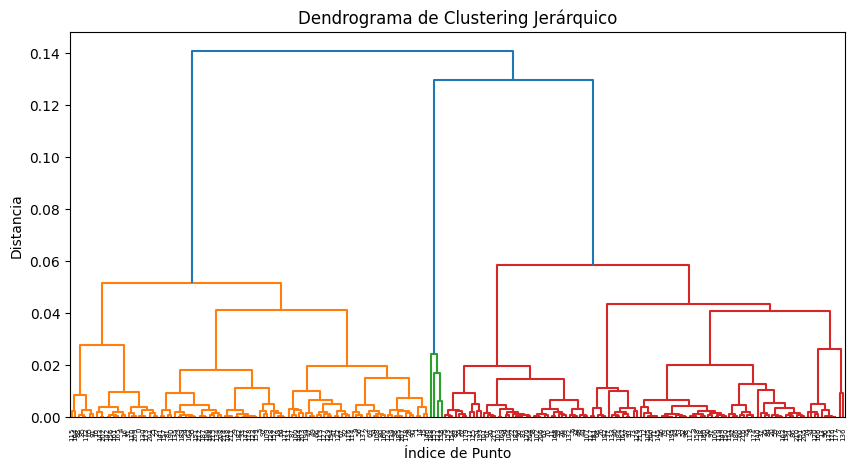

In [193]:
def plot_hca(linked=linked):
    plt.figure(figsize=(10, 5))
    sch.dendrogram(linked)
    plt.title("Dendrograma de Clustering Jerárquico")
    plt.xlabel("Índice de Punto")
    plt.ylabel("Distancia")
    plt.show()
plot_hca()

In [194]:
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import calinski_harabasz_score

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tsr.src.api_osmr import get_matrix, parse_coordinates
from tsr.src.routing import optimize_routes, plot_route
from app.utils.utils import df_factory

import geopandas as gpd


def find_max_diff(input_dictionary: dict, diff_value=1) -> int:
    """
    Finds the number of clusters (k) that maximizes the difference between 
    consecutive Calinski-Harabasz scores.

    Parameters:
    input_dictionary (dict): Keys are cluster numbers (k), values are CH scores.

    Returns:
    int: Optimal number of clusters (k) based on the maximum difference.
    """
    
    sorted_k = sorted(input_dictionary.keys())

    differences = {k: input_dictionary[k] - input_dictionary[sorted_k[i - 1]]
                   for i, k in enumerate(sorted_k[1:], start=1)}

    print(differences)
    # Return the one before based on the max difference    
    best_k = max(differences, key=differences.get) - diff_value

    return best_k 



def find_best_n_clusters(linked, data, min_clusters=20, max_clusters=30, diff_value=1):
    """Find the best number of clusters based on the max difference between the calinski-harabasz scores"""

    scores_dict = {}

    for k in range(min_clusters, max_clusters):  
        labels = fcluster(linked, k, criterion='maxclust') 
        scores_dict[k] = calinski_harabasz_score(data, labels)

    return find_max_diff(scores_dict, diff_value=diff_value)


best_k = find_best_n_clusters(linked, X) 
print(f"Optimal number of clusters: {best_k}")


{21: np.float64(6.30565308741069), 22: np.float64(5.214771864139266), 23: np.float64(6.267443428877925), 24: np.float64(8.599022222264296), 25: np.float64(8.96308424256216), 26: np.float64(11.32312679177079), 27: np.float64(14.299822788366612), 28: np.float64(16.887337553259727), 29: np.float64(16.517418610766413)}
Optimal number of clusters: 27


In [195]:
# Get the optimal number of routes
num_routes = find_best_n_clusters(linked, X, min_clusters=2, max_clusters=6, diff_value=0) 

{3: np.float64(98.18183732497482), 4: np.float64(-22.24627987683968), 5: np.float64(-3.8310484846604425)}


In [196]:
# n_routes = find_best_n_clusters(linked, X, 2, 5, diff_value=0)
route_labels = fcluster(linked, num_routes, criterion='maxclust')
df = pd.DataFrame(X, columns=["latitude", "longitude"])
df["route_id"] = route_labels

In [197]:
df["route_id"]

0      1
1      1
2      1
3      3
4      1
      ..
213    3
214    1
215    1
216    3
217    3
Name: route_id, Length: 218, dtype: int32

In [198]:
cluster_labels = fcluster(linked, best_k, criterion='maxclust')

In [199]:
cluster_labels

array([ 3, 11, 10, 21,  2,  7, 17, 26, 22, 10,  2, 17, 21, 25, 11, 11,  2,
       15, 21,  7, 23, 23, 16,  5,  5,  3, 18,  3, 11,  6, 16,  3, 17,  6,
       25, 23, 16, 23, 11, 17, 19,  9, 22, 21, 17, 22, 21,  9, 17,  9, 21,
       15, 21, 21, 10, 15, 10, 19, 17, 23, 22, 16, 15, 17,  7,  1,  9,  9,
       18, 10, 17, 21, 21, 19, 25, 15, 17, 20, 23, 21, 10,  4,  9, 16, 23,
        1, 23,  8,  1, 15, 11,  1,  7, 19, 16,  5, 25, 21, 21, 17,  8, 16,
       17, 16, 16, 21, 21, 17, 10,  7,  3, 22, 21,  9, 10,  1,  9, 18,  6,
       21, 25, 12,  9,  6, 11, 15, 19,  9,  7,  9,  3,  8, 17, 19,  5,  5,
       27, 10, 12, 11, 24,  4,  2,  2,  8, 21, 11,  6,  6, 21, 21,  5,  7,
       15, 15, 13,  2,  4, 21,  6, 10,  2, 23,  5,  1,  2, 25, 19, 17, 16,
       16,  7,  1,  3, 22, 25, 25, 25, 11, 15, 21, 18,  6, 16, 19, 11, 22,
        5, 14,  5,  4, 23, 18, 15,  9, 21,  5, 23,  5,  9, 21,  3,  2,  8,
       16, 23, 17, 11,  5,  3, 23,  6,  5, 21,  6,  5, 22, 16],
      dtype=int32)

In [200]:
import numpy as np

def compute_cluster_centroids(data, labels):
    unique_clusters = np.unique(labels)
    centroids = []

    for cluster in unique_clusters:
        cluster_points = data[labels == cluster]  # Get all points in this cluster
        centroid = cluster_points.mean(axis=0)  # Compute mean latitude and longitude
        centroids.append(centroid)

    return np.array(centroids)

# Compute centroids
centroids = compute_cluster_centroids(X, cluster_labels)  # X is your original dataset (lat, long)

In [202]:
centroids

array([[41.31336904,  2.0011245 ],
       [41.30944201,  2.00716779],
       [41.30781726,  2.00990462],
       [41.32293189,  2.00767692],
       [41.32123921,  2.01107389],
       [41.31762877,  2.00940394],
       [41.31871605,  2.00575348],
       [41.31291204,  2.00888423],
       [41.31229674,  2.01256511],
       [41.31409318,  2.0156263 ],
       [41.31769808,  2.01284677],
       [41.27400302,  2.04352268],
       [41.28853687,  2.0449508 ],
       [41.27876406,  2.06379766],
       [41.32377494,  2.01671341],
       [41.3207092 ,  2.02206087],
       [41.31979251,  2.01841191],
       [41.32327667,  2.02971761],
       [41.31894946,  2.02857553],
       [41.31844123,  2.03605085],
       [41.31575927,  2.02034292],
       [41.31653546,  2.02596704],
       [41.31396469,  2.02357769],
       [41.30711597,  2.02034876],
       [41.31010097,  2.02800894],
       [41.29338135,  2.02380366],
       [41.29772149,  2.03216367]])

In [203]:
preprocessed_df = pd.DataFrame(data=centroids, columns=["lat", "lng"]).reset_index(names="bus_stop") 
preprocessed_df["bus_stop"] = preprocessed_df["bus_stop"].astype(str)

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from scipy.spatial.distance import cdist
import numpy as np
from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from typing import List, Optional, Tuple
import osmnx as ox
import networkx as nx
import folium
from folium import plugins
import numpy as np

def balanced_kmeans_labels(df, num_routes=3, num_stations_per_route=9):
    """
    Cluster bus stations into balanced groups with equal number of points.

    Args:
        df (DataFrame): DataFrame with columns ['lat', 'lng'].
        num_routes (int): Number of bus routes.
        num_stations_per_route (int): Number of bus stations per route.

    Returns:
        List[int]: List of cluster labels (0, 1, 2) corresponding to input data order.
    """

    
    kmeans = MiniBatchKMeans(n_clusters=num_routes, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df[["lat", "lng"]])

    # Step 2: Balance the Clusters
    df_temp = df.copy()
    df_temp["route_id"] = labels

    while True:
        route_counts = df_temp["route_id"].value_counts().to_dict()
        if all(count == num_stations_per_route for count in route_counts.values()):
            break  

        
        oversized_clusters = {r: c for r, c in route_counts.items() if c > num_stations_per_route}
        undersized_clusters = {r: c for r, c in route_counts.items() if c < num_stations_per_route}

        
        for over_cluster, over_count in oversized_clusters.items():
            excess_points = over_count - num_stations_per_route
            over_points = df_temp[df_temp["route_id"] == over_cluster][["lat", "lng"]].values

            
            for under_cluster, under_count in undersized_clusters.items():
                under_centroid = df_temp[df_temp["route_id"] == under_cluster][["lat", "lng"]].mean().values.reshape(1, -1)
                distances = cdist(over_points, under_centroid)

                
                move_indices = df_temp[df_temp["route_id"] == over_cluster].index[np.argsort(distances.flatten())[:excess_points]]
                df_temp.loc[move_indices, "route_id"] = under_cluster

    return df_temp["route_id"].tolist()




preprocessed_df["route_id"] = balanced_kmeans_labels(preprocessed_df)


In [205]:
def generate_central_station(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds a central bus station (mean of all latitude and longitude) to the dataframe.

    Args:
        df (pd.DataFrame): DataFrame with 'lat' and 'lng' columns.

    Returns:
        pd.DataFrame: Updated DataFrame with an additional central station.
    """
    tmp_lng = np.mean(df["lng"])
    tmp_lat = np.mean(df["lat"])
    tmp_df = pd.DataFrame([{"bus_stop":-1, "lat": tmp_lat, "lng":tmp_lng, "route_id":-1}])
    output_df = pd.concat([tmp_df, df]) 
    return output_df


tmp_df = generate_central_station(preprocessed_df)

In [38]:
# from sklearn.svm import SVC
# from sklearn.cluster import MiniBatchKMeans

# kmeans = MiniBatchKMeans(n_clusters=num_routes, random_state=42, n_init=10)
# preprocessed_df["initial_labels"] = kmeans.fit_predict(preprocessed_df[["lat", "lng"]])

# svm = SVC(kernel="linear", random_state=42)
# svm.fit(preprocessed_df[["lat", "lng"]], preprocessed_df["initial_labels"])

# # Predict the final route labels
# route_id= svm.predict(preprocessed_df[["lat", "lng"]])
# preprocessed_df["initial_labels"]

# # from sklearn.cluster import KMeans
# model = KMeans(n_clusters=3, random_state=1000).fit(preprocessed_df[["lat", "lng"]])
# model.predict(preprocessed_df[["lat", "lng"]])

# # # n_routes = find_best_n_clusters(linked, X, 2, 5, diff_value=0)
# # route_labels = fcluster(linked, num_routes, criterion='maxclust')
# # df = pd.DataFrame(preprocessed_df[["lat", "lng"]])
# # df["route_id"] = route_labels
# # df



# # Repeat the process
# # linked_routes = sch.linkage(preprocessed_df[["lat", "lng"]], method='ward')
# # distance_threshold = linked_routes[-num_routes, 2]
# # route_labels = fcluster(linked_routes, distance_threshold, criterion='distance')
# # route_labels

In [206]:
tmp_df

,bus_stop,lat,lng,route_id
0,-1,41.310703,2.021483,-1
0,0,41.313369,2.001125,0
1,1,41.309442,2.007168,0
2,2,41.307817,2.009905,1
3,3,41.322932,2.007677,0
4,4,41.321239,2.011074,0
5,5,41.317629,2.009404,0
6,6,41.318716,2.005753,0
7,7,41.312912,2.008884,0
8,8,41.312297,2.012565,1


In [40]:
# preprocessed_df = preprocessed_df.drop(columns=["initial_labels"])
preprocessed_df

,bus_stop,lat,lng,route_id
0,0,41.313369,2.001125,0
1,1,41.309442,2.007168,0
2,2,41.307817,2.009905,1
3,3,41.322932,2.007677,0
4,4,41.321239,2.011074,0
5,5,41.317629,2.009404,0
6,6,41.318716,2.005753,0
7,7,41.312912,2.008884,0
8,8,41.312297,2.012565,1
9,9,41.314093,2.015626,1


In [ ]:
# route_ids = tmp_df["route_id"].unique().tolist()

# df_list = [tmp_df[(tmp_df["route_id"] == route_id) | (tmp_df["route_id"] == -1)] for route_id in route_ids if route_id >= 0]

,bus_stop,lat,lng,route_id
0,-1,41.310703,2.021483,-1
15,15,41.320709,2.022061,2
17,17,41.323277,2.029718,2
18,18,41.318949,2.028576,2
19,19,41.318441,2.036051,2
20,20,41.315759,2.020343,2
21,21,41.316535,2.025967,2
22,22,41.313965,2.023578,2
23,23,41.307116,2.020349,2
24,24,41.310101,2.028009,2


In [53]:
from typing import List

def create_k_dataframes(original_df:pd.DataFrame, k: int = 3) -> List:

    route_ids = original_df["route_id"].unique().tolist()

    df_list = [original_df[(original_df["route_id"] == route_id) | (original_df["route_id"] == -1)] for route_id in route_ids if route_id >= 0]

    return df_list

k_df_list = create_k_dataframes(tmp_df)

In [ ]:
# tmp_df = preprocessed_df[preprocessed_df["route_id"]==0]

In [57]:
tmp_df

,bus_stop,lat,lng,route_id
0,-1,41.310703,2.021483,-1
0,0,41.313369,2.001125,0
1,1,41.309442,2.007168,0
3,3,41.322932,2.007677,0
4,4,41.321239,2.011074,0
5,5,41.317629,2.009404,0
6,6,41.318716,2.005753,0
7,7,41.312912,2.008884,0
10,10,41.317698,2.012847,0
14,14,41.323775,2.016713,0


In [ ]:
tmp_df = k_df_list[0]

bus_stops_list = tmp_df.bus_stop
coordinates = parse_coordinates(tmp_df)

response_distances = get_matrix(coordinates)

distances = np.array(response_distances["distances"]).astype(int)
starting_stop = min(tmp_df["bus_stop"].astype(int))

depot_index = int(bus_stops_list.index[bus_stops_list == starting_stop][0])
idx_route = optimize_routes(distances, depot_index, list(bus_stops_list))

Route for vehicle:
 -1 -> 10 -> 5 -> 4 -> 14 -> 3 -> 6 -> 0 -> 1 -> 7 -> -1
Route distance: 10.5km



In [61]:
idx_route

[0, 8, 5, 4, 9, 3, 6, 1, 2, 7, 0]

In [ ]:
from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from typing import List, Optional, Tuple
import osmnx as ox
import networkx as nx
import folium
from folium import plugins
import numpy as np


def print_solution(manager, routing, solution, names=None):
    """
    Prints the solution on the console.

    Args:
        manager: The routing index manager.
        routing: The routing model.
        solution: The solution obtained from the routing solver.
        names (Optional[List[str]]): List of names corresponding to node indices. Defaults to None.
    """
    index = routing.Start(0)
    plan_output = "Route for vehicle:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        idx = manager.IndexToNode(index)
        if names:
            print_value = names[idx]
        else:
            print_value = idx
        plan_output += " {} ->".format(print_value)
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)

    idx = manager.IndexToNode(index)
    if names:
        print_value = names[idx]
    else:
        print_value = idx

    return route_distance / 1000 



def optimize_routes(
    distance_matrix: List[List[int]], depot: int, names: Optional[List[str]] = None
) -> List[int]:
    """
    Solves the vehicle routing problem and returns the optimized route.

    Args:
        distance_matrix (List[List[int]]): 2D list representing the distance matrix between nodes.
        depot (int): Index of the depot (starting point).
        names (Optional[List[str]]): List of names corresponding to node indices. Defaults to None.

    Returns:
        List[int]: The optimized route as a list of node indices.
    """
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(distance_matrix), 1, depot
    )  # num of vehicles set to 1

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console and return the optimized route.
    if solution:
        distance_solution = print_solution(manager, routing, solution, names)
        route = []
        index = routing.Start(0)
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))
        return route, distance_solution
    else:
        return []


def plot_route(
    coordinates: List[Tuple[float, float]], dist: float = 1000, zoom_start: int = 15, mymap: folium.Map = None,
    input_color: str = "blue", central_station:bool = True
) -> folium.Map:



    median_tuple = tuple(np.median(np.array(coordinates), axis=0))

    distances = [
        np.linalg.norm(np.array(t) - np.array(median_tuple)) for t in coordinates
    ]

    closest_index = np.argmin(distances)

    closest_tuple = coordinates[closest_index]

    graph = ox.graph_from_point(
        center_point=closest_tuple, dist=dist, network_type="drive"
    )

    map_center = closest_tuple
    if mymap is None:
        mymap = folium.Map(
            location=map_center, zoom_start=zoom_start, tiles="cartodbpositron"
        )
    
    end_nodes = []
    # Plot the route between each pair of consecutive coordinates
    num_stops = len(coordinates)
    for i in range(num_stops - 1):
        start_node = ox.distance.nearest_nodes(
            graph, coordinates[i][1], coordinates[i][0]
        )
        end_node = ox.distance.nearest_nodes(
            graph, coordinates[i + 1][1], coordinates[i + 1][0]
        )
        route = nx.shortest_path(graph, start_node, end_node, weight="length")
        route_coordinates = [
            (graph.nodes[node]["y"], graph.nodes[node]["x"]) for node in route
        ]

        route_polyline = folium.PolyLine(locations=route_coordinates, color="red")
        mymap.add_child(route_polyline)

        ant_path = plugins.AntPath(
            locations=route_coordinates,
            color=input_color,
            dash_array=[10, 50],
            delay=500,
            weight=5,
        )
        mymap.add_child(ant_path)
        end_nodes.append(route_coordinates[-1])
    

    for coordinate in end_nodes:
        folium.Marker(
            location=coordinate, icon=folium.Icon(color="blue", icon="store")
        ).add_to(mymap)


    return mymap
# , route_coordinates, coordinates, end_nodes


In [165]:
def optimization_wrapper(df: pd.DataFrame):

    bus_stops_list = df.bus_stop
    coordinates = parse_coordinates(df)

    response_distances = get_matrix(coordinates)

    distances = np.array(response_distances["distances"]).astype(int)
    starting_stop = df["bus_stop"].iloc[0]

    depot_index = int(bus_stops_list.index[bus_stops_list == starting_stop][0])
    return optimize_routes(distances, depot_index, list(bus_stops_list))


optimized_routes = [optimization_wrapper(route) for route in k_df_list]

In [ ]:
tmp_df = k_df_list[0]

bus_stops_list = tmp_df.bus_stop
coordinates = parse_coordinates(tmp_df)

response_distances = get_matrix(coordinates)

distances = np.array(response_distances["distances"]).astype(int)
starting_stop = min(tmp_df["bus_stop"].astype(int))

depot_index = int(bus_stops_list.index[bus_stops_list == starting_stop][0])
idx_route = optimize_routes(distances, depot_index, list(bus_stops_list))

[([0, 8, 5, 4, 9, 3, 6, 1, 2, 7, 0], 10.52),
 ([0, 9, 8, 6, 4, 5, 7, 3, 2, 1, 0], 31.732),
 ([0, 8, 9, 6, 3, 4, 2, 1, 5, 7, 0], 9.129)]

In [167]:
optimized_routes[0][0]

[0, 8, 5, 4, 9, 3, 6, 1, 2, 7, 0]

In [168]:
def map_wrapper(df: pd.DataFrame, idx_route, input_color):

    # Create a DataFrame with the best route
    df_best_route = df.iloc[idx_route[0]]

    # Get the coordinates of the best route
    coordinates = list(zip(df_best_route["lat"], df_best_route["lng"]))

    # Plot the best route on a Folium map
    return plot_route(coordinates, dist=30000, zoom_start=11, input_color=input_color)

In [169]:
optimized_maps = [map_wrapper(k_df_list[i], optimized_routes[i], soft_colors[i]) for i in range(len(k_df_list))]

In [ ]:
# optimized_maps[2]

optimized_routes = [optimization_wrapper(route) for route in k_df_list]
optimized_maps = [map_wrapper(k_df_list[i], optimized_routes[i], soft_colors[i]) for i in range(len(k_df_list))]

In [161]:
# distance_solution

In [ ]:
# # Create a DataFrame with the best route
# df_best_route = tmp_df.iloc[idx_route]

# # Get the coordinates of the best route
# coordinates = list(zip(df_best_route["lat"], df_best_route["lng"]))

# # Plot the best route on a Folium map
# my_map = plot_route(coordinates, dist=30000, zoom_start=11)

# # my_map, route_coordinates, coordinates, end_nodes = plot_route(coordinates, dist=30000, zoom_start=11)
# # my_map

In [171]:
# my_map

In [172]:
# tmp_df = k_df_list[0]

# bus_stops_list = tmp_df.bus_stop
# coordinates = parse_coordinates(tmp_df)

# response_distances = get_matrix(coordinates)

# distances = np.array(response_distances["distances"]).astype(int)
# starting_stop = min(tmp_df["bus_stop"].astype(int))

# depot_index = int(bus_stops_list.index[bus_stops_list == starting_stop][0])
# idx_route = optimize_routes(distances, depot_index, list(bus_stops_list))

def merge_folium_maps(maps: List[folium.Map]) -> folium.Map:
    """
    Merges multiple Folium maps into a single map.

    Args:
        maps (List[folium.Map]): List of Folium map objects.

    Returns:
        folium.Map: A single merged Folium map.
    """

    # Step 1: Create a new base map (use the location of the first map)
    base_map = folium.Map(location=maps[0].location, zoom_start=15, tiles="cartodbpositron")

    # Step 2: Add all layers from each map
    for map_obj in maps:
        for child in map_obj._children.values():
            base_map.add_child(child)

    return base_map


In [173]:
solution = merge_folium_maps(optimized_maps)

In [186]:
# solution

Part III: Pararelize

In [181]:
import asyncio
from concurrent.futures import ThreadPoolExecutor
from fastapi import FastAPI
import folium


app = FastAPI()

async def async_process_all(k_df_list, soft_colors):
    loop = asyncio.get_running_loop()

    with ThreadPoolExecutor() as executor:
        # Step 1: Run optimization_wrapper() for all routes in parallel
        optimized_routes = await asyncio.gather(*[
            loop.run_in_executor(executor, optimization_wrapper, df)
            for df in k_df_list
        ])

        # Step 2: Run map_wrapper() in parallel after optimization completes
        optimized_maps = await asyncio.gather(*[
            loop.run_in_executor(executor, map_wrapper, k_df_list[i], optimized_routes[i], soft_colors[i])
            for i in range(len(k_df_list))
        ])

    return optimized_routes, optimized_maps

import nest_asyncio
nest_asyncio.apply()  # Enables async execution in Jupyter

# Now run the async function properly
a, b = await async_process_all(k_df_list, soft_colors)


In [ ]:
# import pandas as pd
# import scipy.cluster.hierarchy as sch
# import matplotlib.pyplot as plt
# # from sklearn.cluster import AgglomerativeClustering
# from sklearn.metrics import calinski_harabasz_score
# import random

# from app.src.api_osmr import get_matrix, parse_coordinates
# from app.src.routing import optimize_routes, plot_route

# from scipy.cluster.hierarchy import fcluster
# from sklearn.metrics import calinski_harabasz_score

# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# import geopandas as gpd
# from typing import List

# from abc import ABC, abstractmethod
# from sklearn.cluster import MiniBatchKMeans
# from scipy.spatial.distance import cdist
# import numpy as np
# from __future__ import print_function
# from ortools.constraint_solver import routing_enums_pb2
# from ortools.constraint_solver import pywrapcp
# from typing import List, Optional, Tuple
# import osmnx as ox
# import networkx as nx
# import folium
# from folium import plugins
# import numpy as np




# random.seed(42)


# class AbstractBaseClass(ABC):

#     @abstractmethod
#     def __init__():
#         pass

#     @abstractmethod
#     def fit():
#         pass

#     @abstractmethod
#     def predict():
#         pass


# from __future__ import print_function
# import logging
# from app.model.abstract_base_class import AbstractBaseClass
# import scipy.cluster.hierarchy as sch
# from sklearn.metrics import calinski_harabasz_score
# from app.src.api_osmr import get_matrix, parse_coordinates
# from app.src.routing import optimize_routes, plot_route

# from scipy.cluster.hierarchy import fcluster
# from sklearn.metrics import calinski_harabasz_score

# import pandas as pd
# import numpy as np

# from typing import List
# from sklearn.cluster import MiniBatchKMeans
# from scipy.spatial.distance import cdist

# from app.utils.soft_colors import SOFT_COLORS



# class ModelHandler(AbstractBaseClass):
#     def __init__(self):
#         pass

#     def load_data(self, path):
#         self.input_data = pd.read_csv(path)
#         self.X = self.input_data[["Latitud", "Longitud"]].values
#         self.soft_colors = SOFT_COLORS


#     def find_max_diff(self, input_dictionary: dict, diff_value=1) -> int:
#         """
#         Finds the number of clusters (k) that maximizes the difference between 
#         consecutive Calinski-Harabasz scores.

#         Parameters:
#         input_dictionary (dict): Keys are cluster numbers (k), values are CH scores.

#         Returns:
#         int: Optimal number of clusters (k) based on the maximum difference.
#         """
        
#         sorted_k = sorted(input_dictionary.keys())

#         differences = {k: input_dictionary[k] - input_dictionary[sorted_k[i - 1]]
#                     for i, k in enumerate(sorted_k[1:], start=1)}

#         return max(differences, key=differences.get) - diff_value

#         return self.best_k 
    
#     def find_best_n_clusters(self, linked, data, min_clusters=20, max_clusters=30, diff_value=1):
#         """Find the best number of clusters based on the max difference between the calinski-harabasz scores"""

#         scores_dict = {}

#         for k in range(min_clusters, max_clusters):  
#             labels = fcluster(linked, k, criterion='maxclust') 
#             scores_dict[k] = calinski_harabasz_score(data, labels)

#         return self.find_max_diff(scores_dict, diff_value=diff_value)
    

#     def get_route_ids(self):
#         print(f"Computing route_ids with num_routes={self.num_routes}")
        
#         route_labels = fcluster(self.linked, self.num_routes, criterion='maxclust')
        
#         print(f"Generated cluster labels: {route_labels}")  # Debugging

#         if len(route_labels) != len(self.X):
#             raise ValueError("Mismatch: route_labels length does not match self.X")

#         self.df = pd.DataFrame(self.X, columns=["latitude", "longitude"])        
#         self.df["route_id"] = route_labels

#         print(self.df["route_id"])

#         if self.df["route_id"].isna().any():
#             raise ValueError("NaN values detected in route_id assignment")



#     def compute_cluster_centroids(self, data, labels):
#         unique_clusters = np.unique(labels)
#         centroids = []

#         for cluster in unique_clusters:
#             cluster_points = data[labels == cluster] 
#             centroid = cluster_points.mean(axis=0)  
#             centroids.append(centroid)

#         return np.array(centroids)


#     def get_bus_station(self):
#         self.cluster_labels = fcluster(self.linked, self.best_k, criterion='maxclust')
#         self.centroids = self.compute_cluster_centroids(self.X, self.cluster_labels)
#         self.df = pd.DataFrame(data=self.centroids, columns=["lat", "lng"]).reset_index(names="bus_stop") 
#         self.df["bus_stop"] = self.df["bus_stop"].astype(str) 
        
        
#     def balanced_kmeans_labels(self, df, num_routes=3, num_stations_per_route=9):
#         """
#         Cluster bus stations into balanced groups with equal number of points.

#         Args:
#             df (DataFrame): DataFrame with columns ['lat', 'lng'].
#             num_routes (int): Number of bus routes.
#             num_stations_per_route (int): Number of bus stations per route.

#         Returns:
#             List[int]: List of cluster labels (0, 1, 2) corresponding to input data order.
#         """

        
#         kmeans = MiniBatchKMeans(n_clusters=num_routes, random_state=42, n_init=10)
#         labels = kmeans.fit_predict(df[["lat", "lng"]])

#         # Step 2: Balance the Clusters
#         df_temp = df.copy()
#         df_temp["route_id"] = labels

#         max_iterations = 100
#         iteration = 0
#         while iteration < max_iterations:
#             route_counts = df_temp["route_id"].value_counts().to_dict()
#             if all(count == num_stations_per_route for count in route_counts.values()):
#                 break
#             iteration += 1

            
#             oversized_clusters = {r: c for r, c in route_counts.items() if c > num_stations_per_route}
#             undersized_clusters = {r: c for r, c in route_counts.items() if c < num_stations_per_route}

            
#             for over_cluster, over_count in oversized_clusters.items():
#                 excess_points = over_count - num_stations_per_route
#                 over_points = df_temp[df_temp["route_id"] == over_cluster][["lat", "lng"]].values

                
#                 for under_cluster, under_count in undersized_clusters.items():
#                     under_centroid = df_temp[df_temp["route_id"] == under_cluster][["lat", "lng"]].mean().values.reshape(1, -1)
#                     distances = cdist(over_points, under_centroid)

                    
#                     move_indices = df_temp[df_temp["route_id"] == over_cluster].index[np.argsort(distances.flatten())[:excess_points]]
#                     df_temp.loc[move_indices, "route_id"] = under_cluster

#         return df_temp["route_id"].tolist()
    

#     def generate_central_station(self, df: pd.DataFrame) -> pd.DataFrame:
#         """
#         Adds a central bus station (mean of all latitude and longitude) to the dataframe.

#         Args:
#             df (pd.DataFrame): DataFrame with 'lat' and 'lng' columns.

#         Returns:
#             pd.DataFrame: Updated DataFrame with an additional central station.
#         """
#         tmp_lng = np.mean(df["lng"])
#         tmp_lat = np.mean(df["lat"])
#         tmp_df = pd.DataFrame([{"bus_stop":-1, "lat": tmp_lat, "lng":tmp_lng, "route_id":-1}])
#         output_df = pd.concat([tmp_df, df]) 
#         return output_df
    

#     def create_k_dataframes(self, original_df:pd.DataFrame) -> List:
#         # print(original_df)
#         route_ids = original_df["route_id"].unique().tolist()

#         df_list = [original_df[(original_df["route_id"] == route_id) | (original_df["route_id"] == -1)] for route_id in route_ids if route_id >= 0]

#         return df_list
    
    
#     def optimization_wrapper(self, df: pd.DataFrame):

#         bus_stops_list = df.bus_stop
#         coordinates = parse_coordinates(df)

#         response_distances = get_matrix(coordinates)

#         distances = np.array(response_distances["distances"]).astype(int)
#         starting_stop = df["bus_stop"].iloc[0]

#         depot_index = int(bus_stops_list.index[bus_stops_list == starting_stop][0])
#         return optimize_routes(distances, depot_index, list(bus_stops_list))
    

#     def map_wrapper(self, df: pd.DataFrame, idx_route, input_color):


#         df_best_route = df.iloc[idx_route[0]]
#         # print(df_best_route)

#         coordinates = list(zip(df_best_route["lat"], df_best_route["lng"]))

#         # print(coordinates)

#         return plot_route(coordinates, dist=30000, zoom_start=11, input_color=input_color)


#     def fit(self, path, balance_stations=True, generate_central_station=True, num_routes=None, method="ward"):
#         self.num_routes = num_routes
#         self.load_data(path)
#         self.linked = sch.linkage(self.X, method=method)
#         self.best_k = self.find_best_n_clusters(linked=self.linked, data=self.X) 

#         if self.num_routes is None:
#             self.num_routes = self.find_best_n_clusters(self.linked, self.X, min_clusters=2, max_clusters=6, diff_value=0)

#         # print(self.df["route_id"])
#         self.get_route_ids() 
#         print(self.df)
#         # self.get_bus_station()
#         # print(self.df["route_id"])
#         # print(self.df["route_id"])
#         # self.get_route_ids() 
#         self.get_bus_station()
#         if balance_stations==True:
            
#             self.df["route_id"] = self.balanced_kmeans_labels(self.df)
#             print("generating labels with kmeans")
        
#         # print(self.df["route_id"])

#         if generate_central_station == True:
#             self.df = self.generate_central_station(self.df)
#             print("generating central station")
        
#         self.k_df_list = self.create_k_dataframes(self.df)



#     def predict(self, path, balance_stations=True, generate_central_station=True, num_routes=None, method="ward"):
#         logging.info("Starting predict function")
#         print("Starting predict function")
#         self.fit(path=path, balance_stations=balance_stations, generate_central_station=generate_central_station, num_routes=num_routes, method=method)
#         # return self.num_routes, self.best_k
#         optimized_routes = [self.optimization_wrapper(route) for route in self.k_df_list]
#         logging.info("Finished optimization_wrapper")
#         print("Finished optimization_wrapper")
#         optimized_maps = [self.map_wrapper(self.k_df_list[i], optimized_routes[i], self.soft_colors[i]) for i in range(len(self.k_df_list))]
#         logging.info("Finished map_wrapper")
#         print("Finished map_wrapper")
#         return optimized_routes, optimized_maps




# import nest_asyncio
# nest_asyncio.apply()   

# PATH = r"C:\JupyterNotebooks\projects\bus-route-builder\app\data\equipaments_model.csv"

# handler = ModelHandler()
# a, b = handler.predict(PATH, balance_stations=False,
#                         # generate_central_station=True, num_routes=2
#                         )

load c:\Users\Vladi\AppData\Local\pypoetry\Cache\virtualenvs\bus-route-builder-i2MxGmv1-py3.10\lib\site-packages\ortools\.libs\zlib1.dll...
load c:\Users\Vladi\AppData\Local\pypoetry\Cache\virtualenvs\bus-route-builder-i2MxGmv1-py3.10\lib\site-packages\ortools\.libs\abseil_dll.dll...
load c:\Users\Vladi\AppData\Local\pypoetry\Cache\virtualenvs\bus-route-builder-i2MxGmv1-py3.10\lib\site-packages\ortools\.libs\utf8_validity.dll...
load c:\Users\Vladi\AppData\Local\pypoetry\Cache\virtualenvs\bus-route-builder-i2MxGmv1-py3.10\lib\site-packages\ortools\.libs\re2.dll...
load c:\Users\Vladi\AppData\Local\pypoetry\Cache\virtualenvs\bus-route-builder-i2MxGmv1-py3.10\lib\site-packages\ortools\.libs\libprotobuf.dll...
load c:\Users\Vladi\AppData\Local\pypoetry\Cache\virtualenvs\bus-route-builder-i2MxGmv1-py3.10\lib\site-packages\ortools\.libs\highs.dll...
load c:\Users\Vladi\AppData\Local\pypoetry\Cache\virtualenvs\bus-route-builder-i2MxGmv1-py3.10\lib\site-packages\ortools\.libs\ortools.dll...
S

In [5]:
a

[]

In [10]:
# !poetry add pyproj
res = merge_folium_maps(b)
res

IndexError: list index out of range

In [7]:
res

NameError: name 'res' is not defined

In [8]:
def merge_folium_maps(maps: List[folium.Map]) -> folium.Map:
        """
        Merges multiple Folium maps into a single map.

        Args:
            maps (List[folium.Map]): List of Folium map objects.

        Returns:
            folium.Map: A single merged Folium map.
        """

        # Step 1: Create a new base map (use the location of the first map)
        base_map = folium.Map(location=maps[0].location, zoom_start=15, tiles="cartodbpositron")

        # Step 2: Add all layers from each map
        for map_obj in maps:
            for child in map_obj._children.values():
                base_map.add_child(child)

        return base_map

In [5]:
res

NameError: name 'res' is not defined

In [ ]:

equipaments = pd.read_csv("data/equipaments_model.csv")
equipaments.head()

X = equipaments[["Latitud", "Longitud"]].values

linked = sch.linkage(X, method=method)









# best_k = find_best_n_clusters(linked, X) 
# print(f"Optimal number of clusters: {best_k}")

# # Get the optimal number of routes
# num_routes = find_best_n_clusters(linked, X, min_clusters=2, max_clusters=6, diff_value=0) 


# n_routes = find_best_n_clusters(linked, X, 2, 5, diff_value=0)
# route_labels = fcluster(linked, num_routes, criterion='maxclust')
# df = pd.DataFrame(X, columns=["latitude", "longitude"])
# df["route_id"] = route_labels

# cluster_labels = fcluster(linked, best_k, criterion='maxclust')

import numpy as np

# def compute_cluster_centroids(data, labels):
#     unique_clusters = np.unique(labels)
#     centroids = []

#     for cluster in unique_clusters:
#         cluster_points = data[labels == cluster]  # Get all points in this cluster
#         centroid = cluster_points.mean(axis=0)  # Compute mean latitude and longitude
#         centroids.append(centroid)

#     return np.array(centroids)

# Compute centroids
# centroids = compute_cluster_centroids(X, cluster_labels)  # X is your original dataset (lat, long)

# preprocessed_df = pd.DataFrame(data=centroids, columns=["lat", "lng"]).reset_index(names="bus_stop") 
# preprocessed_df["bus_stop"] = preprocessed_df["bus_stop"].astype(str)

from sklearn.cluster import MiniBatchKMeans
from scipy.spatial.distance import cdist
import numpy as np

# def balanced_kmeans_labels(df, num_routes=3, num_stations_per_route=9):
#     """
#     Cluster bus stations into balanced groups with equal number of points.

#     Args:
#         df (DataFrame): DataFrame with columns ['lat', 'lng'].
#         num_routes (int): Number of bus routes.
#         num_stations_per_route (int): Number of bus stations per route.

#     Returns:
#         List[int]: List of cluster labels (0, 1, 2) corresponding to input data order.
#     """

    
#     kmeans = MiniBatchKMeans(n_clusters=num_routes, random_state=42, n_init=10)
#     labels = kmeans.fit_predict(df[["lat", "lng"]])

#     # Step 2: Balance the Clusters
#     df_temp = df.copy()
#     df_temp["route_id"] = labels

#     while True:
#         route_counts = df_temp["route_id"].value_counts().to_dict()
#         if all(count == num_stations_per_route for count in route_counts.values()):
#             break  

        
#         oversized_clusters = {r: c for r, c in route_counts.items() if c > num_stations_per_route}
#         undersized_clusters = {r: c for r, c in route_counts.items() if c < num_stations_per_route}

        
#         for over_cluster, over_count in oversized_clusters.items():
#             excess_points = over_count - num_stations_per_route
#             over_points = df_temp[df_temp["route_id"] == over_cluster][["lat", "lng"]].values

            
#             for under_cluster, under_count in undersized_clusters.items():
#                 under_centroid = df_temp[df_temp["route_id"] == under_cluster][["lat", "lng"]].mean().values.reshape(1, -1)
#                 distances = cdist(over_points, under_centroid)

                
#                 move_indices = df_temp[df_temp["route_id"] == over_cluster].index[np.argsort(distances.flatten())[:excess_points]]
#                 df_temp.loc[move_indices, "route_id"] = under_cluster

#     return df_temp["route_id"].tolist()




# preprocessed_df["route_id"] = balanced_kmeans_labels(preprocessed_df)

# def generate_central_station(df: pd.DataFrame) -> pd.DataFrame:
#     """
#     Adds a central bus station (mean of all latitude and longitude) to the dataframe.

#     Args:
#         df (pd.DataFrame): DataFrame with 'lat' and 'lng' columns.

#     Returns:
#         pd.DataFrame: Updated DataFrame with an additional central station.
#     """
#     tmp_lng = np.mean(df["lng"])
#     tmp_lat = np.mean(df["lat"])
#     tmp_df = pd.DataFrame([{"bus_stop":-1, "lat": tmp_lat, "lng":tmp_lng, "route_id":-1}])
#     output_df = pd.concat([tmp_df, df]) 
#     return output_df


# tmp_df = generate_central_station(preprocessed_df)

# from typing import List

# def create_k_dataframes(original_df:pd.DataFrame, k: int = 3) -> List:

#     route_ids = original_df["route_id"].unique().tolist()

#     df_list = [original_df[(original_df["route_id"] == route_id) | (original_df["route_id"] == -1)] for route_id in route_ids if route_id >= 0]

#     return df_list

# k_df_list = create_k_dataframes(tmp_df)

In [182]:
a

[([0, 8, 5, 4, 9, 3, 6, 1, 2, 7, 0], 10.52),
 ([0, 9, 8, 6, 4, 5, 7, 3, 2, 1, 0], 31.732),
 ([0, 8, 9, 6, 3, 4, 2, 1, 5, 7, 0], 9.129)]

In [183]:
b

In [184]:
solution = merge_folium_maps(b)
solution

In [106]:
len(route_coordinates)
route_coordinates[-1]

(41.3116427, 2.0203646)

In [107]:
coordinates

[(41.31070264459594, 2.0214830205945074),
 (41.3176980775, 2.0128467691666665),
 (41.317628766, 2.0094039419999996),
 (41.32123921142857, 2.011073892857143),
 (41.32377493999999, 2.016713406363636),
 (41.322931892499994, 2.00767692),
 (41.318716045, 2.00575347875),
 (41.31336903571429, 2.0011245042857144),
 (41.30944201111111, 2.007167785555555),
 (41.312912042, 2.008884226),
 (41.31070264459594, 2.0214830205945074)]

In [112]:
my_map

In [103]:
# tmp_map = folium.Map(
#         location=coordinates[0], zoom_start = 15, tiles="cartodbpositron"
#     )


# folium.Marker(
#         location=coordinates[0], icon=folium.Icon(color="green", icon="play")
#     ).add_to(tmp_map)
#     #         location=graph.nodes[node]["x"], icon=folium.Icon(color="green", icon="play")
#     # ).add_to(mymap)
# for idx, coordinate in enumerate(coordinates[1:-1]):
#     print(route_coordinates[idx])
#     print(coordinate)
#     folium.Marker(
#             location=coordinate, icon=folium.Icon(color="blue", icon="store")
#         ).add_to(tmp_map)
#         #             location=route_coordinates[idx], icon=folium.Icon(color="blue", icon="store")
#         # ).add_to(mymap)

# tmp_map

In [78]:
tmp_map

In [207]:
# tmp_df = preprocessed_df[preprocessed_df["route_id"]==1]

# # df_best_route
# bus_stops_list = tmp_df.bus_stop
# coordinates = parse_coordinates(tmp_df)

# response_distances = get_matrix(coordinates)

# distances = np.array(response_distances["distances"]).astype(int)
# starting_stop = tmp_df["bus_stop"].iloc[0]

# depot_index = int(bus_stops_list.index[bus_stops_list == starting_stop][0])
# idx_route = optimize_routes(distances, depot_index, list(bus_stops_list))

# # Create a DataFrame with the best route
# df_best_route = tmp_df.iloc[idx_route]

# # Get the coordinates of the best route
# coordinates = list(zip(df_best_route["lat"], df_best_route["lng"]))

# # Plot the best route on a Folium map
# my_map = plot_route(coordinates, dist=30000, zoom_start=11)
# my_map

In [208]:
# tmp_df = preprocessed_df[preprocessed_df["route_id"]==2]

# # df_best_route
# bus_stops_list = tmp_df.bus_stop
# coordinates = parse_coordinates(tmp_df)

# response_distances = get_matrix(coordinates)

# distances = np.array(response_distances["distances"]).astype(int)
# starting_stop = tmp_df["bus_stop"].iloc[0]

# depot_index = int(bus_stops_list.index[bus_stops_list == starting_stop][0])
# idx_route = optimize_routes(distances, depot_index, list(bus_stops_list))

# # Create a DataFrame with the best route
# df_best_route = tmp_df.iloc[idx_route]

# # Get the coordinates of the best route
# coordinates = list(zip(df_best_route["lat"], df_best_route["lng"]))

# # Plot the best route on a Folium map
# my_map = plot_route(coordinates, dist=30000, zoom_start=11)
# my_map

In [60]:
# # Iterate over each unique city in the places data
# for stop in preprocessed_df.bus_stop.unique():
#     print(f"Planning route for {stop}")

#     # Select the first 10 points of sales for the current city
#     df_bus = preprocessed_df[preprocessed_df.bus_stop == stop][:10].reset_index(drop=True)

#     # Parse coordinates for the selected points of sales
#     coordinates = parse_coordinates(df_bus)

#     # Get the distance matrix for the selected points of sales using the OSRM API
#     response_distances = get_matrix(coordinates)

#     # Convert the distances to integer values (required by ortools)
#     distances = np.array(response_distances["distances"]).astype(int)

#     # Set the names of the points of sales for labeling the route
#     pos_names = list(df_city.name)

#     # Setting the farthest point as the start point
#     # Calculate the median tuple for the distance matrix
#     coordinates_tuples = np.array(response_distances["distances"]).astype(int)
#     median_tuple = tuple(np.median(np.array(coordinates_tuples), axis=0))

#     # Calculate the Euclidean distance of each tuple from the median tuple
#     distances_tuples = [
#         np.linalg.norm(np.array(t) - np.array(median_tuple)) for t in coordinates_tuples
#     ]

#     # Find the index of the tuple with the maximum distance
#     farthest_index = max(enumerate(distances_tuples), key=lambda x: x[1])[0]

#     # Optimize the route using the distance matrix and farthest point index as the starting point
#     best_route = optimize_routes(distances, farthest_index, pos_names)[:-1]

#     # Save the best route to a CSV file with the city name in the output folder
#     df_city.name[best_route].reset_index(drop=True).to_csv(
#         f"data/output/{city}_routing.csv"
#     )

#     # Plot the best route on the map for the city "Ulldecona" (first city in the iteration)
#     if city == "Ulldecona":
#         df_best_route = df_city.iloc[best_route]
#         coordinates = list(zip(df_best_route["lat"], df_best_route["lng"]))
#         my_map = plot_route(coordinates, dist=2000)

# # Display the final Folium map with the best route for the city "Ulldecona"
# my_map

In [ ]:



ch_score = calinski_harabasz_score(X_scaled, clusters)
print(f"Calinski-Harabasz Index: {ch_score}")

In [33]:
from sklearn.cluster import AgglomerativeClustering
agg_clust = AgglomerativeClustering()
assigned_clust = agg_clust.fit_predict(X)

In [34]:
assigned_clust

array([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0])